# **EDA Images**

**Course:** Master in Big Data, Data Science & AI — Master Thesis  
**Author:** Carlota Trigo La Blanca  

*This notebook will be used to do the exploratory data analysis of the images from the database developed for my Master Thesis. The variables analyzed are those extracted from the images themselves.*

## **Initialization**

In [67]:
# !pip -q install opencv-python-headless==4.10.0.84 imagehash umap-learn torch torchvision --upgrade

In [68]:
from google.colab import auth
auth.authenticate_user()

In [69]:
import os, hashlib
from io import BytesIO
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import cv2
import gcsfs
from tqdm import tqdm
import imagehash

import io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fsspec  # requiere gcsfs instalado para gs://

In [70]:
METADATA_CSV = "gs://ucm_tfm_datos_carlotatrigo/metadata_clean.csv"
IMG_DIR_GCS  = "gs://ucm_tfm_datos_carlotatrigo/images/images"

In [71]:
df = pd.read_csv(METADATA_CSV)

def has(col): return col in df.columns
COL_IMAGE  = "image_id" if has("image_id") else None
COL_DIAG   = "diagnosis_grouped" if has("diagnosis_grouped") else None
COL_LESION = "lesion_type" if has("lesion_type") else None
COL_ORIGIN = "origin_dataset" if has("origin_dataset") else None

print("Columnas detectadas:", {"image_id": COL_IMAGE, "diagnosis_grouped": COL_DIAG, "lesion_type": COL_LESION, "origin_dataset": COL_ORIGIN})
if COL_IMAGE is None:
    raise ValueError("No encuentro la columna con los nombres de imagen (image_id).")

Columnas detectadas: {'image_id': 'image_id', 'diagnosis_grouped': 'diagnosis_grouped', 'lesion_type': 'lesion_type', 'origin_dataset': 'origin_dataset'}


In [72]:
# =========================
# 3) INDEXAR IMÁGENES EN GCS (normalizando a 'gs://')
# =========================
import os
import gcsfs
from collections import defaultdict

fs = gcsfs.GCSFileSystem()
EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

def _norm_key(x: str) -> str:
    """Devuelve clave tipo 'bucket/path/file.jpg' (sin 'gs://')."""
    s = str(x)
    return s[5:] if s.startswith("gs://") else s

def _to_gs(x: str) -> str:
    """Asegura que la ruta lleva prefijo 'gs://bucket/path/file'."""
    s = str(x)
    return s if s.startswith("gs://") else "gs://" + s

def _gs_join(prefix: str, tail: str) -> str:
    """Une 'gs://bucket/prefix' + 'tail' → 'gs://bucket/prefix/tail'."""
    p = _norm_key(prefix).strip("/")
    t = str(tail).lstrip("/")
    return "gs://" + "/".join([p, t]) if p else "gs://" + t

# Listado recursivo (gcsfs puede devolver sin 'gs://')
raw = fs.glob(IMG_DIR_GCS.rstrip("/") + "/**")
# Filtra a imágenes y normaliza a 'gs://...'
gcs_imgs = [_to_gs(p) for p in raw if os.path.splitext(p)[1].lower() in EXTS]

print(f"Imágenes encontradas en {IMG_DIR_GCS}: {len(gcs_imgs)}")
print("Ejemplos normalizados:", gcs_imgs[:3])
assert all(u.startswith("gs://") for u in gcs_imgs), "Aún hay rutas sin 'gs://'"

# Índices para resolver image_id -> gs://...
filename_to_gs = {}               # "foo.jpg" -> gs://.../foo.jpg
stem_to_gs = defaultdict(list)    # "foo"     -> [gs://.../foo.jpg, gs://.../foo.png]

for uri in gcs_imgs:
    name = uri.split("/")[-1]
    stem, _ = os.path.splitext(name)
    filename_to_gs[name] = uri
    stem_to_gs[stem].append(uri)

def resolve_gs(image_id: str):
    """Resuelve un image_id a un URI gs:// aunque falte extensión o tenga subcarpetas."""
    s = str(image_id).strip().replace("\\","/")
    base = os.path.basename(s)

    # 1) si trae subcarpetas relativas al prefijo, prueba directo
    cand = _gs_join(IMG_DIR_GCS, s)
    if cand in gcs_imgs:
        return cand

    # 2) match exacto por nombre de archivo
    if base in filename_to_gs:
        return filename_to_gs[base]

    # 3) match por 'stem' (sin extensión)
    stem, ext = os.path.splitext(base)
    if ext == "" and stem in stem_to_gs:
        return stem_to_gs[stem][0]  # si hay varias, elige la primera

    # 4) probar extensiones comunes
    for e in EXTS:
        cand2 = _gs_join(IMG_DIR_GCS, base + e)
        if cand2 in gcs_imgs:
            return cand2

    return None

# Resuelve cada image_id a 'gs://...'
resolved_uris = df[COL_IMAGE].astype(str).map(resolve_gs)
print("Rutas resueltas:", int(resolved_uris.notna().sum()), "/", len(resolved_uris))
print("Ejemplos NO resueltos:", df.loc[resolved_uris.isna(), COL_IMAGE].astype(str).head(10).tolist())


Imágenes encontradas en gs://ucm_tfm_datos_carlotatrigo/images/images: 71715
Ejemplos normalizados: ['gs://ucm_tfm_datos_carlotatrigo/images/images/ISIC_0000000.jpg', 'gs://ucm_tfm_datos_carlotatrigo/images/images/ISIC_0000001.jpg', 'gs://ucm_tfm_datos_carlotatrigo/images/images/ISIC_0000002.jpg']
Rutas resueltas: 71715 / 71715
Ejemplos NO resueltos: []


In [73]:
def qc_metrics_any(uri_or_path):
    """Calcula métricas de calidad (brillo, contraste, blur, bordes, etc.) desde gs:// o ruta local."""
    try:
        is_gcs = str(uri_or_path).startswith("gs://")

        if is_gcs:
            info = fs.info(uri_or_path)
            size_bytes = int(info.get("size", 0))
            with fs.open(uri_or_path, "rb") as f:
                data = f.read()
            sha256 = hashlib.sha256(data).hexdigest()
            im = Image.open(BytesIO(data)).convert("RGB")
        else:
            size_bytes = os.path.getsize(uri_or_path)
            with open(uri_or_path, "rb") as f:
                sha256 = hashlib.sha256(f.read()).hexdigest()
            im = Image.open(uri_or_path).convert("RGB")

        im = ImageOps.exif_transpose(im)
        w, h = im.size
        arr = np.array(im)
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

        # Métricas básicas
        brightness = float(gray.mean())
        contrast   = float(gray.std())
        blur_var   = float(cv2.Laplacian(gray, cv2.CV_64F).var())
        dark_ratio   = float((gray < 30).mean())
        bright_ratio = float((gray > 225).mean())
        aspect = w / h if h != 0 else np.nan

        # Bordes negros (tira de 5 px en bordes)
        bs = 5 if min(w,h) >= 20 else max(1, min(w,h)//4)
        border = np.concatenate([
            gray[:bs,:].ravel(), gray[-bs:,:].ravel(),
            gray[:,:bs].ravel(), gray[:,-bs:].ravel()
        ])
        black_border_ratio = float((border < 10).mean())

        # Vigneteado (centro - esquinas)
        c_h, c_w = h//2, w//2
        center = gray[max(0,c_h-32):c_h+32, max(0,c_w-32):c_w+32]
        corners = np.concatenate([
            gray[:min(32,h), :min(32,w)].ravel(),
            gray[:min(32,h), -min(32,w):].ravel(),
            gray[-min(32,h):, :min(32,w)].ravel(),
            gray[-min(32,h):, -min(32,w):].ravel(),
        ])
        vignette_delta = float(center.mean() - corners.mean()) if corners.size>0 and center.size>0 else 0.0

        # Heurísticas de artefactos
        edges = cv2.Canny(gray, 80, 200)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100,
                                minLineLength=int(0.5*min(w,h)), maxLineGap=10)
        has_long_line = int(lines is not None and len(lines) > 0)

        b, g, r = cv2.split(arr)
        bluish_mask  = (b.astype(np.int32)-r.astype(np.int32) > 40) & (b.astype(np.int32)-g.astype(np.int32) > 20) & (b > 120)
        greenish_mask= (g.astype(np.int32)-r.astype(np.int32) > 30) & (g > 120)
        marker_ratio = float((bluish_mask | greenish_mask).mean())

        # Perceptual hashes
        ahash = imagehash.average_hash(im).__str__()
        phash = imagehash.phash(im).__str__()

        return dict(
            image_path=str(uri_or_path),
            width=w, height=h, aspect=aspect, size_bytes=size_bytes,
            brightness=brightness, contrast=contrast, blur_var=blur_var,
            dark_ratio=dark_ratio, bright_ratio=bright_ratio,
            black_border_ratio=black_border_ratio, vignette_delta=vignette_delta,
            sha256=sha256, ahash=ahash, phash=phash,
            has_long_line=has_long_line, marker_ratio=marker_ratio
        )
    except Exception as e:
        return {"image_path": str(uri_or_path), "error": str(e)}

### Sampling and metrics extraction

In [74]:
MAX_IMAGES = 10
uris = resolved_uris.dropna()
if (MAX_IMAGES is not None) and (len(uris) > MAX_IMAGES):
    uris = uris.sample(MAX_IMAGES, random_state=42)

print(f"Procesando {len(uris)} imágenes desde GCS...")

rows = []
for uri in tqdm(uris.tolist()):
    rows.append(qc_metrics_any(uri))

Q = pd.DataFrame(rows)
Q['image_id'] = Q['image_path'].map(lambda x: os.path.basename(x))

print("Métricas calculadas: ", Q.shape)
# display(Q.head())

Procesando 10 imágenes desde GCS...


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

Métricas calculadas:  (10, 18)


### Combining with metadata file#

In [75]:
merged_df = df[['image_id', 'origin_dataset', 'lesion_type', 'body_region', 'diagnosis_grouped']].merge(Q, on='image_id', how='left')
merged_df.dropna(inplace = True)
merged_df

,image_id,origin_dataset,lesion_type,body_region,diagnosis_grouped,image_path,width,height,aspect,size_bytes,...,blur_var,dark_ratio,bright_ratio,black_border_ratio,vignette_delta,sha256,ahash,phash,has_long_line,marker_ratio
5982,ISIC_0027385.jpg,HAM1000,benign,trunk,vasc,gs://ucm_tfm_datos_carlotatrigo/images/images/...,600.0,450.0,1.333333,261004.0,...,148.283666,0.000000e+00,0.000052,0.000000,-62.284912,7c064472988dd42f27ff7c287d53a122e21cffb0681865...,3c7c6ee6e6fe7e3c,d63399cc6633998c,0.0,0.002874
16073,ISIC_0056124.jpg,ISIC2019,malignant,lower_extremity,bcc,gs://ucm_tfm_datos_carlotatrigo/images/images/...,1024.0,1024.0,1.000000,568930.0,...,17.675572,3.168488e-02,0.000000,0.196338,109.113037,3b25f6ed8f88cd2f65d4376bf453dd49fd230e9adf1ba1...,3c7fe7c3c3f77f3e,8017005f155f57fe,0.0,0.066411
17302,ISIC_0058120.jpg,ISIC2019,malignant,lower_extremity,scc_akiec,gs://ucm_tfm_datos_carlotatrigo/images/images/...,1024.0,1024.0,1.000000,585673.0,...,20.045145,7.204056e-03,0.000000,0.062109,105.380127,9f6ae49dfc9da1bfaec76e5767ce5c317e8f6d14515d62...,0e5fc1c143afff5e,91561415157e57f6,0.0,0.131049
30861,ISIC_1020369.jpg,ISIC2020,benign,lower_extremity,unknown,gs://ucm_tfm_datos_carlotatrigo/images/images/...,1872.0,1053.0,1.777778,135841.0,...,17.091565,0.000000e+00,0.000000,0.000000,-60.058838,18bf0a9dd7a393bc84ededa9a1bc9ecef451427f499417...,7e3e7e6667677f7e,a2de8d3363c88da9,0.0,0.997525
35479,ISIC_2057707.jpg,ISIC2020,benign,trunk,unknown,gs://ucm_tfm_datos_carlotatrigo/images/images/...,6000.0,4000.0,1.500000,1438143.0,...,20.854055,2.458333e-06,0.087535,0.000000,9.815918,b158c26d19798a2b5f25d31b158a3238a233724bc13e84...,7c7c7e6666647c3c,c288997726cc5fc9,0.0,0.257939
38668,ISIC_2792035.jpg,ISIC2020,benign,lower_extremity,unknown,gs://ucm_tfm_datos_carlotatrigo/images/images/...,6000.0,4000.0,1.500000,1307298.0,...,12.704705,4.166667e-08,0.088987,0.000000,31.973877,448ee3583a434ab5b7e43935828223c1f25f261d954835...,3c3e66667e7e3e3c,867719d9662619d9,0.0,0.070435
55017,ISIC_6545294.jpg,MIL10K,benign,lower_extremity,df,gs://ucm_tfm_datos_carlotatrigo/images/images/...,600.0,450.0,1.333333,35900.0,...,66.025152,0.000000e+00,0.000000,0.000000,-36.459717,67d851ed7d0e6ae419b326c87193f77d48fd1923752c94...,ffe7c3c3c3c3e7ff,a06dd29b891decb2,0.0,0.241063
59172,ISIC_7512268.jpg,ISIC2020,benign,trunk,unknown,gs://ucm_tfm_datos_carlotatrigo/images/images/...,6000.0,4000.0,1.500000,1070977.0,...,5.326336,1.250000e-07,0.131100,0.000000,4.589844,b09a8d76dbeba9d221d5ea258257425a2c5330debe4ff1...,3c7e6e666e7e3c3c,d1b34ccc33334dcc,0.0,0.401226
64373,ISIC_8709698.jpg,ISIC2020,benign,unknown,unknown,gs://ucm_tfm_datos_carlotatrigo/images/images/...,3264.0,2448.0,1.333333,629696.0,...,59.961330,4.367060e-03,0.000221,0.000053,160.952393,781e92c58fa744f23736fcb4112d897e9aca737732d6b1...,3c7e5efafe5e0600,d0d916b6477c1936,0.0,0.564459
67875,ISIC_9514708.jpg,ISIC2020,benign,upper_extremity,unknown,gs://ucm_tfm_datos_carlotatrigo/images/images/...,1872.0,1053.0,1.777778,126522.0,...,13.890695,0.000000e+00,0.000000,0.000000,-25.866211,b19dfda921d61cac830fe973c003b1b0f591e989802b29...,ffcf8787878787cf,b1c4c0c6ceb64eec,0.0,1.000000


### Visualize an image per diagnostic

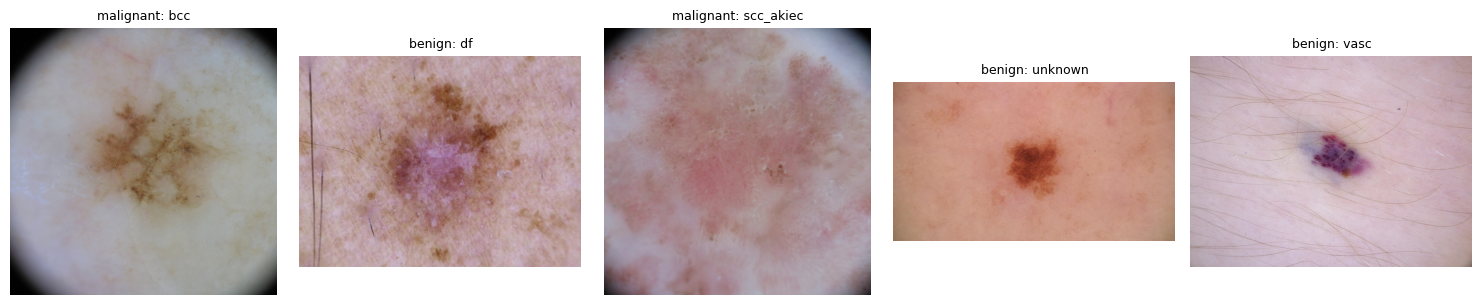

In [76]:
def build_uri(row):
    p = row.get("image_path")
    if pd.isna(p) or str(p).strip() == "":
        return f"{IMG_DIR_GCS}/{row['image_id']}"
    return str(p)

def open_image_any(uri):
    """Abre imagen desde gs:// o ruta local y respeta orientación EXIF."""
    try:
        s = str(uri)
        if s.startswith("gs://"):
            with fsspec.open(s, "rb") as f:
                data = f.read()
            im = Image.open(io.BytesIO(data)).convert("RGB")
        else:
            im = Image.open(s).convert("RGB")
        return ImageOps.exif_transpose(im)
    except Exception as e:
        return None  # si falla, lo señalamos en el subplot

# Prepara una muestra: 1 fila representativa por diagnosis_grouped
tmp = merged_df.dropna(subset=["diagnosis_grouped"]).copy()
tmp["img_uri"] = tmp.apply(build_uri, axis=1)

reps = (tmp.sort_values(["diagnosis_grouped", "origin_dataset", "image_id"])
           .groupby("diagnosis_grouped", as_index=False)
           .nth(0)
           .reset_index(drop=True))

n = len(reps)
if n == 0: raise ValueError("No hay imágenes con diagnosis_grouped.")

ncols = min(5, max(1, n))
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3.0*ncols, 3.0*nrows))
axes = np.atleast_1d(axes).ravel()

for ax, (_, row) in zip(axes, reps.iterrows()):
    ax.axis("off")
    im = open_image_any(row["img_uri"])
    title = f"{row['lesion_type']}: {row['diagnosis_grouped']}"
    if im is None:
        ax.text(0.5, 0.5, "No se pudo abrir", ha="center", va="center", fontsize=9)
        ax.set_title(title, fontsize=9)
        continue
    ax.imshow(im)
    ax.set_title(title, fontsize=9)

# Apaga ejes sobrantes si la rejilla es mayor que n
for ax in axes[len(reps):]:
    ax.axis("off")

plt.tight_layout()
plt.show()